<a href="https://colab.research.google.com/github/SamwelJane/NLP-analysis/blob/master/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The aim of this analysis was to determine whether a statement was real or not *real*

In [ ]:
!pip install nlppreprocess

In [14]:
# libraries
import pandas as pd
import numpy as np
import os
import re
from nlppreprocess import NLP

In [4]:
#load train and test dataset
train= pd.read_csv('train.csv')
test= pd.read_csv('test.csv')

In [6]:
# dataset overview
print('shape of train and test sets are:',train.shape,test.shape)
print('columns of the sets are:', train.columns,test.columns)

shape of train and test sets are: (7613, 5) (3263, 4)
columns of the sets are: Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object') Index(['id', 'keyword', 'location', 'text'], dtype='object')


In [10]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [12]:
# remove urls from the texts
def remove_urls(text):
  return re.sub(r"http\S+","",text)
  """re.sub(a,b,c))
  ->it means that, in text 'c' we find 'a' and replace it with 'b'
   """
train['text'] = train['text'].apply(remove_urls)
test['text'] = test['text'].apply(remove_urls)

In [16]:
# Install nlp to remove stop words such as i, we, have
nlp =NLP()
train['text'] = train['text'].apply(nlp.process)
test['text']= test['text'].apply(nlp.process)

In [24]:
# tokenizing the text
from tensorflow import keras
from keras_preprocessing.text import Tokenizer as toke
token= Tokenizer(num_words=10000)
token.fit_on_texts(train['text'])
sequences = token.texts_to_sequences(train['text'])


token_test =toke(num_words=5000)
token_test.fit_on_texts(test['text'])
sequences_test = token_test.texts_to_sequences(test['text'])

In [28]:
# keras preprocessing  will help to trim length text to a uniform length
from keras.preprocessing.sequence import pad_sequences
input_tensor= pad_sequences(sequences,maxlen=30)
test_tensor=pad_sequences(sequences_test,maxlen=30)

In [32]:
# train test split of data
from sklearn.model_selection import  train_test_split
X_train, X_test,y_train, y_test = train_test_split(input_tensor,train['target'], test_size = 0.3)

## Model

In [38]:
model =keras.Sequential()
model.add(keras.layers.Embedding(100000, 64))
model.add(keras.layers.LSTM(64,recurrent_dropout = 0.5, return_sequences = True))

model.add(keras.layers.LSTM(64,return_sequences=True))
model.add(keras.layers.LSTM(32))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          6400000   
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_4 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 6,479,553
Trainable params: 6,479,553
Non-trainable params: 0
____________________________________________

In [40]:
model.compile(optimizer='adam',metrics=['accuracy'],loss='binary_crossentropy')
model.fit(X_train,y_train,batch_size=100,epochs=20)

Epoch 1/20
54/54 [==============================] - 9s 162ms/step - loss: 0.6409 - accuracy: 0.6343
Epoch 2/20
54/54 [==============================] - 9s 159ms/step - loss: 0.3862 - accuracy: 0.8373
Epoch 3/20
54/54 [==============================] - 9s 160ms/step - loss: 0.2549 - accuracy: 0.9009
Epoch 4/20
54/54 [==============================] - 9s 159ms/step - loss: 0.1832 - accuracy: 0.9353
Epoch 5/20
54/54 [==============================] - 9s 158ms/step - loss: 0.1449 - accuracy: 0.9523
Epoch 6/20
54/54 [==============================] - 9s 158ms/step - loss: 0.1226 - accuracy: 0.9600
Epoch 7/20
54/54 [==============================] - 9s 159ms/step - loss: 0.1019 - accuracy: 0.9657
Epoch 8/20
54/54 [==============================] - 9s 159ms/step - loss: 0.0900 - accuracy: 0.9707
Epoch 9/20
54/54 [==============================] - 9s 159ms/step - loss: 0.0814 - accuracy: 0.9735
Epoch 10/20
54/54 [==============================] - 9s 159ms/step - loss: 0.0745 - accuracy: 0.9741

## Model Evaluation

In [41]:
evaluation= model.evaluate(X_test,y_test)
print(evaluation)

72/72 [==============================] - 1s 13ms/step - loss: 1.4659 - accuracy: 0.7496
[1.4658560752868652, 0.74956214427948]


In [42]:
rid= np.array(test.id)
rid

array([    0,     2,     3, ..., 10868, 10874, 10875])

In [45]:
# fitting the train and test in the predict model
fine =model.predict_classes(test_tensor)
fine=fine.flatten()
df=pd.DataFrame({'ID':rid, 'target':fine})
df.to_csv('answer.csv')

In [51]:
# convert the  answers to csv
dd = pd.read_csv('answer.csv')

In [53]:
dd=dd.drop(columns=['Unnamed: 0'])

In [54]:
dd.head()

,ID,target
0,0,1
1,2,0
2,3,1
3,9,1
4,11,1


In [56]:
# total number of real and not real
dd.target.value_counts()

0    1778
1    1485
Name: target, dtype: int64

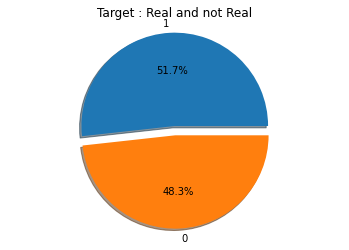

In [63]:
import matplotlib.pyplot as plt

hls = dd["ID"].sample(2)
edl = dd["target"].unique().tolist()
explode = [0,0.1]

plt.pie(hls, explode=explode, labels=edl, autopct = '%1.1f%%', shadow = True)
plt.axis('equal')
plt.title('Target : Real and not Real')
plt.show()


* Real: 1,

* Not`real : 0